In [49]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, AncillaRegister, execute, Aer
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm.notebook import tqdm
import pandas as pd
import json

# Define necessary subroutines

In [50]:
# Define (de-)normalization routines
def norm(mini,maxi,x):
    a = (x+abs(mini))/abs(abs(maxi)+abs(mini))
    return a

def denorm(mini,maxi,z, k_scale):
    c = z*abs(abs(maxi)+abs(mini))
    return c

# Define routine for calculating the corresponding rotation angle
def prob2angle(y):
    b = np.arcsin(np.sqrt(y))
    return b

# normalization for gearbox
def norm_gb(z,maxi,steps,u_f,d_f,S0):
    maxi2 = S0*( u_f**steps - ( u_f*(u_f**steps - 1)/( steps*(u_f-1) ) ))            # geometric sum
    #maxi2 = S0* u_f**steps / 2
    c = (z + maxi2) / (2*maxi2)
    return c

# Addition routine

In [51]:
def adding(nosaaq,nohq,vals):
    
    # Create string to use for formating integer in k-digit binary
    help_string_a = '0' + str(nohq) + 'b'
    
    # Define register
    s = QuantumRegister(nosaaq)
    v = QuantumRegister(nosaaq)
    a = QuantumRegister(nohq)
    g = QuantumRegister(1)

    # Start the circuit    
    qc = QuantumCircuit(s,v,a,g)

    # Uniformly-controlled rotations to store values for addition in respective amplitudes
    for i, l_val in enumerate(vals):
        temp_l = []
        for j, val in enumerate(l_val):
            temp_l.append(2*val[2])        
        qc.ucry(temp_l, s[-(i+1):][::-1], v[-(i+1)])

    # Prepare ancillary qubits for addition
    qc.h(a)

    # Perform the addition
    for i in range(nosaaq):
        hq_list = [v[i]]
        for p in range(nohq):
            hq_list.append(a[p])

        # Create binary representation for i
        bin_help = format(i, help_string_a)    

        for lll, element in enumerate(bin_help):
            if element == str(1):
                qc.x(a[lll])        

        qc.mcx(hq_list, g[0])

        for jjj, element in enumerate(bin_help):
            if element == str(1):
                qc.x(a[jjj])  

    # Uncompute the ancillary qubits used for addition
    qc.h(a)

    qo = qc.to_gate()
    qo.name = 'ampl. adding'
    return qo

# Single gearbox

In [52]:
def single_gb(nosaaq,vals):
    s = QuantumRegister(nosaaq)
    u = QuantumRegister(2)
    qc = QuantumCircuit(s,u)


    qc.ry(np.pi/2, u[0])
    for i, l_val in enumerate(vals):
        temp_l = []
        for j, val in enumerate(l_val):
            temp_l.append(-(1/nosaaq)*np.pi*val[3])       
        qc.ucry(temp_l, s[-(i+1):][::-1], u[0])
        if i == len(vals)-1:
            temp_l = []
            for j, val in enumerate(l_val):
                temp_l.append(np.pi*val[3])
            qc.ucry(temp_l, s[-(i+1):][::-1], u[0])
                
    qc.cx(u[0],u[1])

    qc.ry(-np.pi/2, u[0])
    for i, l_val in enumerate(vals):
        temp_l = []
        for j, val in enumerate(l_val):
            temp_l.append((1/nosaaq)*np.pi*val[3])        
        qc.ucry(temp_l, s[-(i+1):][::-1], u[0])
        if i == len(vals)-1:
            temp_l = []
            for j, val in enumerate(l_val):
                temp_l.append(-np.pi*val[3])
            qc.ucry(temp_l, s[-(i+1):][::-1], u[0])
        
    qo = qc.to_gate()
    qo.name = 'gearbox'
    return qo

# Denominator $d_i(x)$

$ \frac{d_0(x)}{2} = 0.91526 $

$ \frac{d_2(x)}{2} = 0.485281 \cos(2x)^2 $

$ \frac{d_4(x)}{2} = 0.0832611 \cos(4x)^2 $

$ \frac{d_6(x)}{2} = 0.0142853 \cos(6x)^2.$

In [53]:
factor0 = 0.91526
factor2 = 0.485281
factor4 = 0.0832611
factor6 = 0.0142853

In [54]:
def denomi(nosaaq, vals, factor, freq):

    s = QuantumRegister(nosaaq, 's')
    ud = QuantumRegister(2, 'u')
    f = QuantumRegister(1, 'final')
    
    
    af = 2*np.arcsin(np.sqrt(factor))
    qc = QuantumCircuit(s,ud,f)
    if freq != 0:
        
        '''
        for i, l_val in enumerate(vals):
            temp_l = []
            for j, val in enumerate(l_val):
                temp_l.append(( freq /nosaaq)*np.pi*val[3])       
            qc.ucry(temp_l, s[-(i+1):][::-1], ud[0])
        '''

        qc.ry(freq*np.pi/2, ud[0])
        for i, l_val in enumerate(vals):
            temp_l = []
            for j, val in enumerate(l_val):
                temp_l.append(-(freq/nosaaq)*np.pi*val[3])       
            qc.ucry(temp_l, s[-(i+1):][::-1], ud[0])
            if i == len(vals)-1:
                temp_l = []
                for j, val in enumerate(l_val):
                    temp_l.append(freq*np.pi*val[3])
                qc.ucry(temp_l, s[-(i+1):][::-1], ud[0])


            
        qc.x(ud[0])

        qc.ry(af, ud[1])

        qc.mcx([ud[0],ud[1]], f[0])
        
    else:
        
        qc.ry(af, ud[1])
        qc.cx(ud[1], f[0])
    
    #print(qc)
    
    qo = qc.to_gate()
    qo.name = 'denominator'+str(freq)
    return qo

# Construct the addition tree and other used values

In [55]:
# Set number of steps
steps = 2

shots = 1000 * 100

# Set addition propteries
S0 = 1
u_f = 1.3
d_f = 0.8
asset_changes = [u_f, d_f]

up1 = S0*u_f
down1 = S0*d_f

# Calculate min/max
maxi = S0 * u_f**steps
mini = 0


# Create nested list where each steps is represented by a list, where each point is represented
# by a list containing the value, the normalized value, and the corresponding rotation angle
orig_list = [[up1,norm(mini,maxi,up1),prob2angle(norm(mini,maxi,up1)),norm_gb(up1,maxi,steps,u_f,d_f,S0)],[down1,norm(mini,maxi,down1),prob2angle(norm(mini,maxi,down1)),norm_gb(down1,maxi,steps,u_f,d_f,S0)]]
vals = []
vals.append(orig_list)

for i in range(steps-1):
    tmp_list = []
    for j in vals[i]:
        for change in asset_changes:
            l = j[0]*change
            tmp_list.append([l,norm(mini,maxi,l),prob2angle(norm(mini,maxi,l)),norm_gb(l,maxi,steps,u_f,d_f,S0)])
    vals.append(tmp_list)    
#print(vals)


# Calculate number of ancillary qubits
nohq = int(np.ceil(np.log2(steps)))

# Compute values needed for timesteps not equal to power of 2
nhat = int(2**nohq)
k_scale = steps / nhat



# Construct the circuit

In [56]:
def buildCircuit(steps,vals,k_scale,mini,maxi,denominator_number):
    # Define circuit elements
    s = QuantumRegister(steps, 'states')
    v = QuantumRegister(steps, 'terms for addition')
    a = QuantumRegister(nohq, 'addition ancillary')
    g = QuantumRegister(1, 'addition result')
    u = QuantumRegister(2, 'gearbox qubits')
    r = QuantumRegister(1, 'add g result')

    ud = QuantumRegister(2, 'denom help')
    df = QuantumRegister(1, 'denom f')
    f = QuantumRegister(1, 'final')

    # Define circuit subroutines
    add_circ = adding(steps,nohq,vals)
    gearbox = single_gb(steps,vals)
    #rescaler = rescale(mini,maxi,k_scale)
    
    if denominator_number == 0:
        denominator = denomi(steps,vals,factor0,0)
    elif denominator_number == 2:
        denominator = denomi(steps,vals,factor2,2)
    elif denominator_number == 4:
        denominator = denomi(steps,vals,factor4,4)
    elif denominator_number == 6:
        denominator = denomi(steps,vals,factor6,6)
    else:
        sys.exit()
        
    # Initiate circuit
    qc = QuantumCircuit(s,v,a,g,u,r,ud,df,f)

    # Complete the circuit
    qc.append(add_circ, s[:]+v[:]+a[:]+g[:])
    qc.append(gearbox, s[:]+u[:])
    qc.ccx(g[0],u[1],r[0])
    #qc.append(rescaler, [u[1],r[0]])
    qc.barrier()
    qc.append(denominator, s[:]+ud[:]+df[:])    
    qc.barrier()
    qc.ccx(r[0],df[0],f[0])
    
    return qc

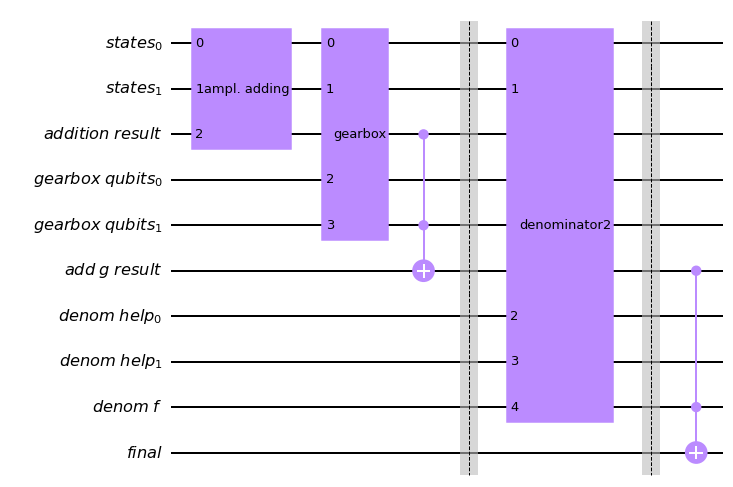

In [57]:
def adding_forSubtraction(nosaaq,nohq,vals):
    
    # Create string to use for formating integer in k-digit binary
    help_string_a = '0' + str(nohq) + 'b'
    
    # Define register
    s = QuantumRegister(nosaaq)
    g = QuantumRegister(1)

    # Start the circuit    
    qc = QuantumCircuit(s,g)

    # Uniformly-controlled rotations to store values
    for i, l_val in enumerate(vals):
        temp_l = []
        for j, val in enumerate(l_val):
            temp_l.append(2*val[2])        
        qc.ucry(temp_l, s[:][::-1], g[0])

    qo = qc.to_gate()
    qo.name = 'ampl. adding'
    return qo

def buildCircuit_forSubtraction(steps,vals,k_scale,mini,maxi,denominator_number):
    # Define circuit elements
    s = QuantumRegister(steps, 'states')
    g = QuantumRegister(1, 'addition result')
    u = QuantumRegister(2, 'gearbox qubits')
    r = QuantumRegister(1, 'add g result')

    ud = QuantumRegister(2, 'denom help')
    df = QuantumRegister(1, 'denom f')
    f = QuantumRegister(1, 'final')

    # Define circuit subroutines
    add_circ = adding_forSubtraction(steps,nohq,vals[-1:])
    gearbox = single_gb(steps,vals)
    #rescaler = rescale(mini,maxi,k_scale)
    
    if denominator_number == 0:
        denominator = denomi(steps,vals,factor0,0)
    elif denominator_number == 2:
        denominator = denomi(steps,vals,factor2,2)
    elif denominator_number == 4:
        denominator = denomi(steps,vals,factor4,4)
    elif denominator_number == 6:
        denominator = denomi(steps,vals,factor6,6)
    else:
        sys.exit()
        
    # Initiate circuit
    qc = QuantumCircuit(s,g,u,r,ud,df,f)

    # Complete the circuit
    qc.append(add_circ, s[:]+g[:])
    qc.append(gearbox, s[:]+u[:])
    qc.ccx(g[0],u[1],r[0])
    #qc.append(rescaler, [u[1],r[0]])
    qc.barrier()
    qc.append(denominator, s[:]+ud[:]+df[:])    
    qc.barrier()
    qc.ccx(r[0],df[0],f[0])
    
    return qc


qc0_s = buildCircuit_forSubtraction(steps,vals,k_scale,mini,maxi,denominator_number=2)
#qc0_s.decompose().draw(output='mpl')
qc0_s.draw(output='mpl')

# Run algorithm and print/save data

In [58]:
# Define circuit elements
s = QuantumRegister(steps, 'states')
v = QuantumRegister(steps, 'terms for addition')
a = QuantumRegister(nohq, 'addition ancillary')
g = QuantumRegister(1, 'addition result')
u = QuantumRegister(2, 'gearbox qubits')
r = QuantumRegister(1, 'add_g result')

ud = QuantumRegister(2, 'use denom')

df = QuantumRegister(1, 'denom_f')
f = QuantumRegister(1, 'final')
cr = ClassicalRegister(2, 'bits')

# define second circuit elements
s2 = QuantumRegister(steps, 'states')
g2 = QuantumRegister(1, 'addition result')
u2 = QuantumRegister(2, 'gearbox qubits')
r2 = QuantumRegister(1, 'add_g result')

ud2 = QuantumRegister(2, 'use denom')

df2 = QuantumRegister(1, 'denom_f')
f2 = QuantumRegister(1, 'final')
cr2 = ClassicalRegister(2, 'bits')


# Create string to use for formating integer in k-digit binary
help_string_a = '0' + str(steps) + 'b'

# Set average variabels to zero
num_average = 0
num_aver_max = 0
exp_average = 0
gb_average = 0


# Print header
print('state\tcir\tgb\tnum\tmax\tD circ\tD gb\tD circ gb\teval')

# Iniate lists for plotting
diff_list = []
result_list = []
data_list = []

# Loop over all paths
for i in range(2**steps):

    # Create binary representation of path index i
    bin_help = format(i, help_string_a)

    # Calculate exact result numerically
    numeric = 0
    num_max = 0
    for d in range(0,len(bin_help),1):
        h_summi = 1
        for ele in range(d+1):
            if bin_help[ele] == '0':
                h_summi *= u_f
            else:
                h_summi *= d_f
        numeric += h_summi
    numeric /= len(bin_help)
    numeric = h_summi - numeric
    num_max = max(0,numeric)   

    # Rotation angle
    rot_angle = norm_gb(numeric,maxi,steps,u_f,d_f,S0)*(1/2)*np.pi

    # Gearbox result
    gb_res = ((np.sin(rot_angle))**4/((np.sin(rot_angle))**4+(np.cos(rot_angle))**4))*numeric

    
    qc0_h = buildCircuit(steps,vals,k_scale,mini,maxi,denominator_number=0)
    qc2_h = buildCircuit(steps,vals,k_scale,mini,maxi,denominator_number=2)
    qc4_h = buildCircuit(steps,vals,k_scale,mini,maxi,denominator_number=4)
    qc6_h = buildCircuit(steps,vals,k_scale,mini,maxi,denominator_number=6)

    qc0_hs = buildCircuit_forSubtraction(steps,vals,k_scale,mini,maxi,denominator_number=0)
    qc2_hs = buildCircuit_forSubtraction(steps,vals,k_scale,mini,maxi,denominator_number=2)
    qc4_hs = buildCircuit_forSubtraction(steps,vals,k_scale,mini,maxi,denominator_number=4)
    qc6_hs = buildCircuit_forSubtraction(steps,vals,k_scale,mini,maxi,denominator_number=6)
            
    # Initiate circuit
    qc0 = QuantumCircuit(s,v,a,g,u,r,ud,df,f,cr)
    qc2 = QuantumCircuit(s,v,a,g,u,r,ud,df,f,cr)
    qc4 = QuantumCircuit(s,v,a,g,u,r,ud,df,f,cr)
    qc6 = QuantumCircuit(s,v,a,g,u,r,ud,df,f,cr)

    qc0_s = QuantumCircuit(s2,g2,u2,r2,ud2,df2,f2,cr2)
    qc2_s = QuantumCircuit(s2,g2,u2,r2,ud2,df2,f2,cr2)
    qc4_s = QuantumCircuit(s2,g2,u2,r2,ud2,df2,f2,cr2)
    qc6_s = QuantumCircuit(s2,g2,u2,r2,ud2,df2,f2,cr2)

    # Prepare state register according to pathway
    help_qu = bin_help[::-1]
    for gg in range(len(help_qu)):
        if help_qu[gg] == '1':
            qc0.x(s[gg])
            qc2.x(s[gg])
            qc4.x(s[gg])
            qc6.x(s[gg])
            
            qc0_s.x(s2[gg])
            qc2_s.x(s2[gg])
            qc4_s.x(s2[gg])
            qc6_s.x(s2[gg])


    #####################################################################
    #####################################################################

    # Complete the circuit
    qc0.append(
        qc0_h,
        s[:]+v[:]+a[:]+g[:]+u[:]+r[:]+ud[:]+df[:]+f[:]
    )
    
    qc2.append(
        qc2_h,
        s[:]+v[:]+a[:]+g[:]+u[:]+r[:]+ud[:]+df[:]+f[:]
    )

    qc4.append(
        qc4_h,
        s[:]+v[:]+a[:]+g[:]+u[:]+r[:]+ud[:]+df[:]+f[:]
    )

    qc6.append(
        qc6_h,
        s[:]+v[:]+a[:]+g[:]+u[:]+r[:]+ud[:]+df[:]+f[:]
    )
    
    qc0.barrier()
    qc0.measure((u[0],f[0]), cr)
    
    qc2.barrier()
    qc2.measure((u[0],f[0]), cr)

    qc4.barrier()
    qc4.measure((u[0],f[0]), cr)
    
    qc6.barrier()
    qc6.measure((u[0],f[0]), cr)

    #####################################################################
    #####################################################################

    # Complete the circuit
    qc0_s.append(
        qc0_hs,
        s2[:]+g2[:]+u2[:]+r2[:]+ud2[:]+df2[:]+f2[:]
    )
    
    qc2_s.append(
        qc2_hs,
        s2[:]+g2[:]+u2[:]+r2[:]+ud2[:]+df2[:]+f2[:]
    )

    qc4_s.append(
        qc4_hs,
        s2[:]+g2[:]+u2[:]+r2[:]+ud2[:]+df2[:]+f2[:]
    )

    qc6_s.append(
        qc6_hs,
        s2[:]+g2[:]+u2[:]+r2[:]+ud2[:]+df2[:]+f2[:]
    )
    
    qc0_s.barrier()
    qc0_s.measure((u2[0],f2[0]), cr2)
    
    qc2_s.barrier()
    qc2_s.measure((u2[0],f2[0]), cr2)

    qc4_s.barrier()
    qc4_s.measure((u2[0],f2[0]), cr2)
    
    qc6_s.barrier()
    qc6_s.measure((u2[0],f2[0]), cr2)

    #####################################################################
    #####################################################################
    
    backend = Aer.get_backend('qasm_simulator')
    
    # FIRST PART
    counts0 = execute(qc0,backend=backend,shots=shots).result().get_counts()
    result0 = counts0.get('10',0)/shots
    
    counts2 = execute(qc2,backend=backend,shots=shots).result().get_counts()
    result2 = counts2.get('10',0)/shots
    
    counts4 = execute(qc4,backend=backend,shots=shots).result().get_counts()
    result4 = counts4.get('10',0)/shots
    
    counts6 = execute(qc6,backend=backend,shots=shots).result().get_counts()
    result6 = counts6.get('10',0)/shots

    # SECOND PART
    counts0_s = execute(qc0_s,backend=backend,shots=shots).result().get_counts()
    result0_s = counts0_s.get('10',0)/shots
    
    counts2_s = execute(qc2_s,backend=backend,shots=shots).result().get_counts()
    result2_s = counts2_s.get('10',0)/shots
    
    counts4_s = execute(qc4_s,backend=backend,shots=shots).result().get_counts()
    result4_s = counts4_s.get('10',0)/shots
    
    counts6_s = execute(qc6_s,backend=backend,shots=shots).result().get_counts()
    result6_s = counts6_s.get('10',0)/shots
    

    res = {
        'result_ST_0': result0_s,
        'result_ST_2': result2_s,
        'result_ST_4': result4_s,
        'result_ST_6': result6_s,
        'result_mean_0': result0,
        'result_mean_2': result2,
        'result_mean_4': result4,
        'result_mean_6': result6,
    }

    result = (result0_s - result2_s + result4_s - result6_s) - (1/k_scale)*(result0 - result2 + result4 - result6)
    

    fin = denorm(mini,maxi,2*result, k_scale)
    #fin = result

    #res['final_result'] = result

    # Append plotting list
    result_list.append([rot_angle,bin_help,fin,gb_res,num_max])

    # Calculate difference
    diff_gb_circ = abs(fin-gb_res) 
    diff_gb = abs(gb_res-num_max) 
    diff = abs(fin-num_max)    
    diff_list.append(diff)

    # Calculate averages
    num_average += numeric
    num_aver_max += num_max
    exp_average += fin
    gb_average += gb_res

    # Evaluate performance w.r.t gearbox
    if diff < diff_gb:
        evalu = 'better'
    elif diff == diff_gb:
        evalu = 'equal'
    else:
        evalu = 'worse'

    # Print result
    print(f'{bin_help}\t{round(fin,3)}\t{round(gb_res,3)}\t{round(numeric,3)}\t{round(num_max,3)}\t{round(diff,3)}\t{round(diff_gb,3)}\t{round(diff_gb_circ,3)}\t\t{evalu}')

    data = {
        'state': str(bin_help),
        'circuit': fin,
        'expected': gb_res,
        'numeric': numeric,
        'num max': num_max,
        'diff circ': diff,
        'diff exp': diff_gb,
        'diff circ exp': diff_gb_circ,
        'shots': shots,
    }

    data_list.append(data)

# Normalize averages
num_average /= (2**steps)
num_aver_max /= (2**steps)
exp_average /= (2**steps)
gb_average /= (2**steps)

# Calcualte average of difference
diff_av = abs(exp_average-num_aver_max)
diff_av_gb = abs(gb_average-num_aver_max)
diff_av_gb_c = abs(exp_average-gb_average)

#Print averages
print('_______________________________________________________________________')
print(f'H\t{round(exp_average,3)}\t{round(gb_average,3)}\t{round(num_average,3)}\t{round(num_aver_max,3)}\t{round(diff_av,3)}\t{round(diff_av_gb,3)}\t{round(diff_av_gb_c,3)}')

state	cir	gb	num	max	D circ	D gb	D circ gb	eval
00	0.198	0.195	0.195	0.195	0.003	0.0	0.003		worse
01	-0.001	-0.001	-0.13	0	0.001	0.001	0.0		worse
10	0.114	0.119	0.12	0.12	0.006	0.001	0.004		worse
11	-0.004	-0.005	-0.08	0	0.004	0.005	0.001		better
_______________________________________________________________________
H	0.077	0.077	0.026	0.079	0.002	0.002	0.0


In [59]:
# Prepare data for plotting
result_list_s = sorted(result_list, key=lambda x: x[0])[::-1]
ang_list = []
circ_list = []
gb_list = []
ex_list = []
state_list = []
for ele in range(len(result_list_s)):
    ang_list.append(result_list_s[ele][0])
    circ_list.append(result_list_s[ele][2])
    gb_list.append(result_list_s[ele][3])
    ex_list.append(result_list_s[ele][4])
    state_list.append(result_list_s[ele][1])

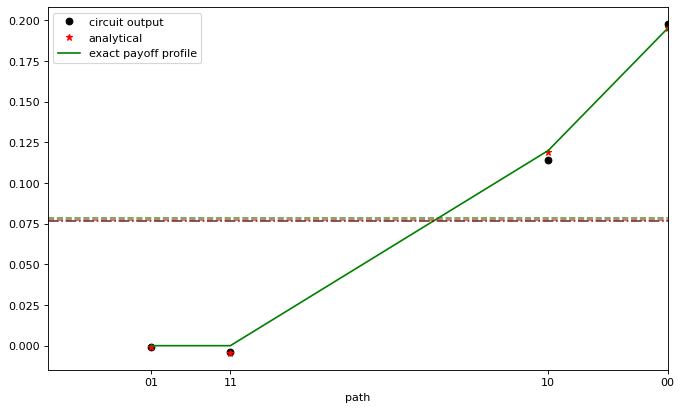

In [60]:
# Plot payoff profiles
fig, ax = plt.subplots(figsize=(10, 6), dpi = 80)

ax.plot(ang_list, circ_list, 'o', label='circuit output', color='black')
ax.plot(ang_list, gb_list, '*', label='analytical', color='red')
ax.plot(ang_list, ex_list, label='exact payoff profile', color='green')
plt.axhline(y=exp_average, color='black', linestyle='dashdot', alpha = 0.7)
plt.axhline(y=gb_average, color='red', linestyle='--', alpha = 0.7)
plt.axhline(y=num_aver_max, color='green', linestyle='--', alpha = 0.7)
ax.set_xlabel('path')
ax.set_xlim(0,np.pi/2)
ax.set_xticks(ang_list)
ax.set_xticklabels(state_list)

ax.legend(loc="upper left")

In [61]:
from qiskit import transpile, IBMQ
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag

qc = qc0

basis_gates = ['u3', 'cx']

if(IBMQ.active_account() is None):
    IBMQ.load_account()   
    
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend("simulator_extended_stabilizer")
tr_qc = transpile(qc, backend, basis_gates)
dag_circuit = circuit_to_dag(tr_qc)
counts_gates = dag_circuit.count_ops()
counts_gates_longest_path = dag_circuit.count_ops_longest_path()

In [62]:
qcd = qc.decompose().decompose().decompose().decompose().decompose()

df = pd.DataFrame(data_list)

name = 'fsplMVP_1gb_'+str(steps)+'ts_'+str(int(shots*4))+'Shots_individual'

properties = [{
    'name': name,
    'shots per circuit per timestep': int(shots),
    'timesteps': steps,
    'decompose depth': sum([counts_gates[x] for x in counts_gates]),
    'decompose width': qc.width(),
    'basis_gates used': basis_gates,
    'basis_gates counts': counts_gates,
    'Mean Circ Result': np.mean(df['circuit']),
    'Mean Diff Circ %': np.mean(df['diff circ'])*100,
    'Mean Expected Result': np.mean(df['expected']),
    'Mean Diff Circ Exp %': np.mean(df['diff circ exp'])*100,
    'Exact Result': np.mean(df['num max']),
    'Amplitude Estimation': False,
    'Number of circuits': 4,
}]

df_prop = pd.DataFrame(properties)

filename_data = df_prop['name'][0] + '_data.csv'
filename_prop = df_prop['name'][0] + '_properties.csv'

#df.to_csv(filename_data)
#df_prop.to_csv(filename_prop, index=False)

df_prop

,name,shots per circuit per timestep,timesteps,decompose depth,decompose width,basis_gates used,basis_gates counts,Mean Circ Result,Mean Diff Circ %,Mean Expected Result,Mean Diff Circ Exp %,Exact Result,Amplitude Estimation,Number of circuits
0,fsplMVP_1gb_2ts_400000Shots_individual,100000,2,120,15,"[u3, cx]","{'u3': 63, 'cx': 52, 'barrier': 3, 'measure': 2}",0.076903,0.326225,0.077132,0.21446,0.07875,False,4


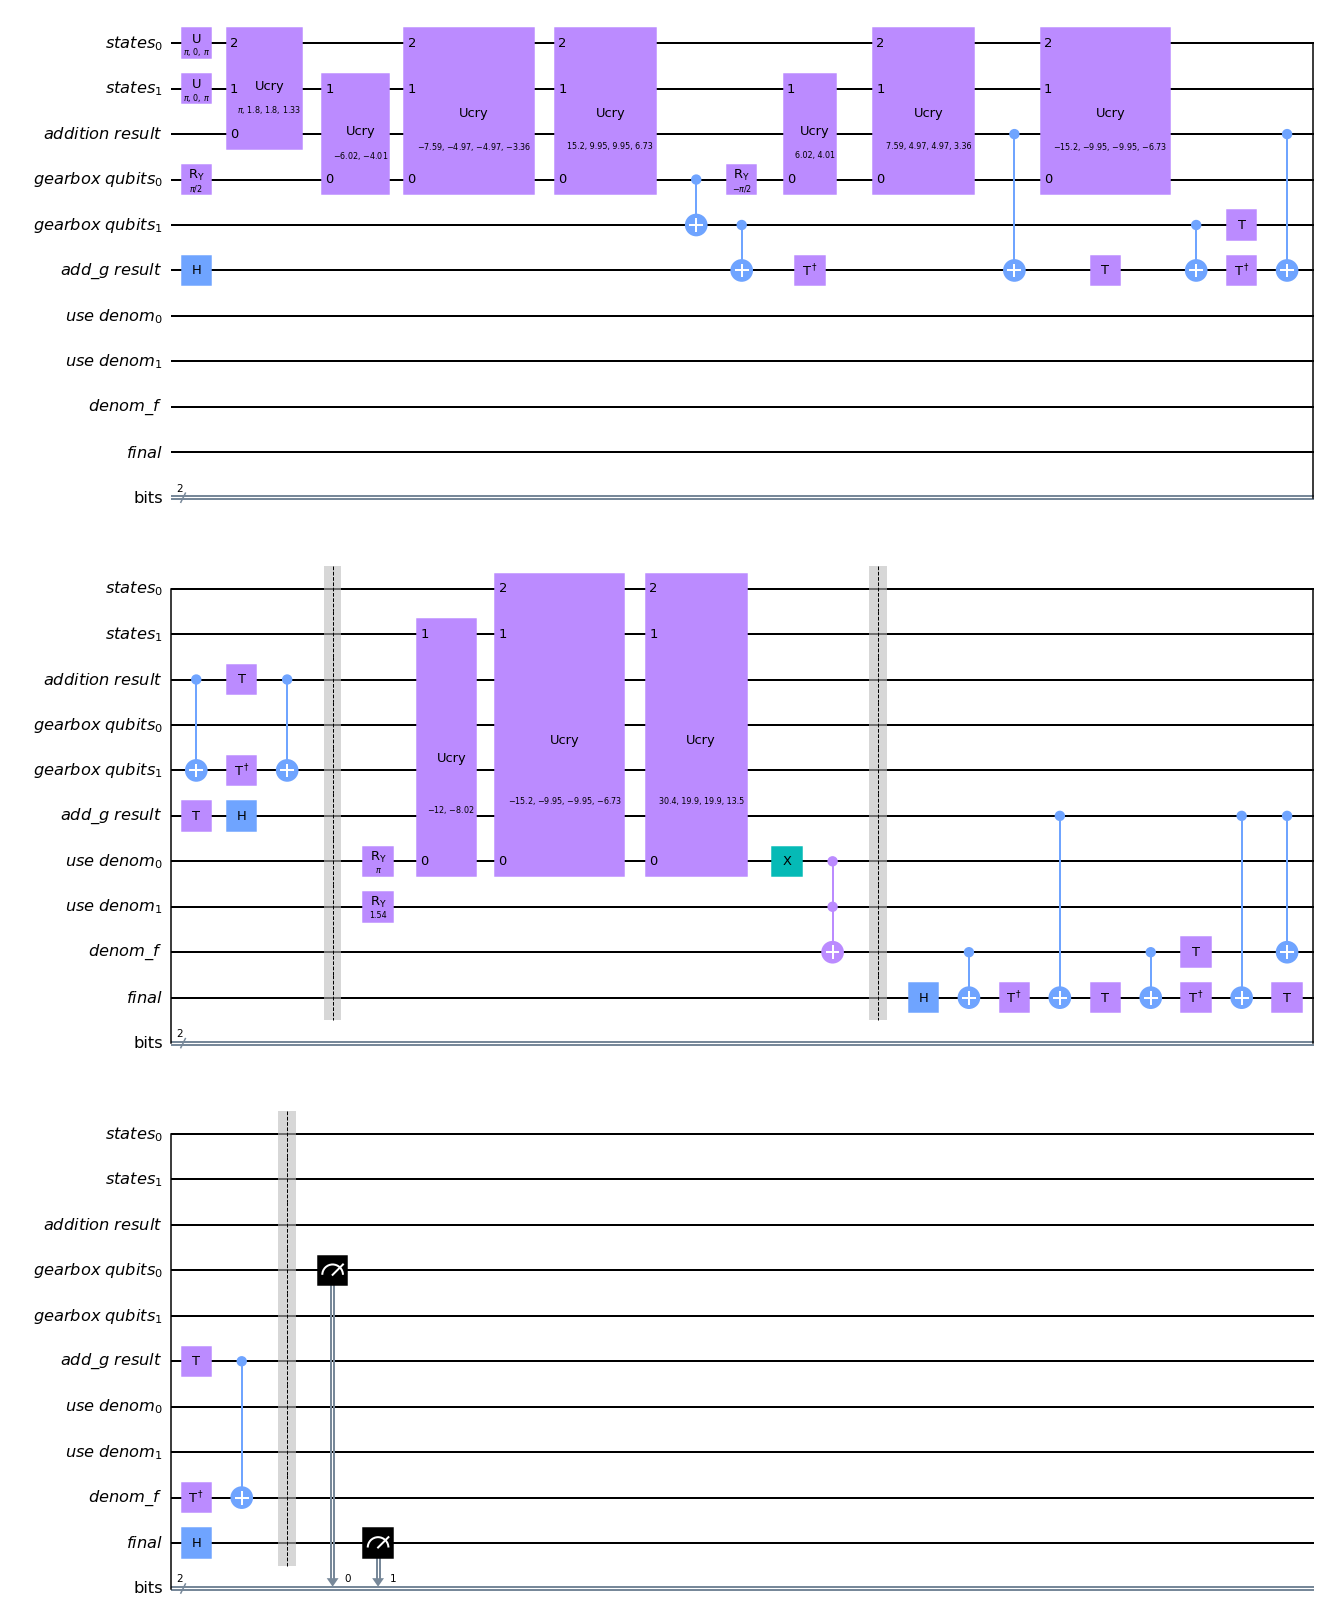

In [63]:
qc2_s.decompose().decompose().draw(output='mpl')

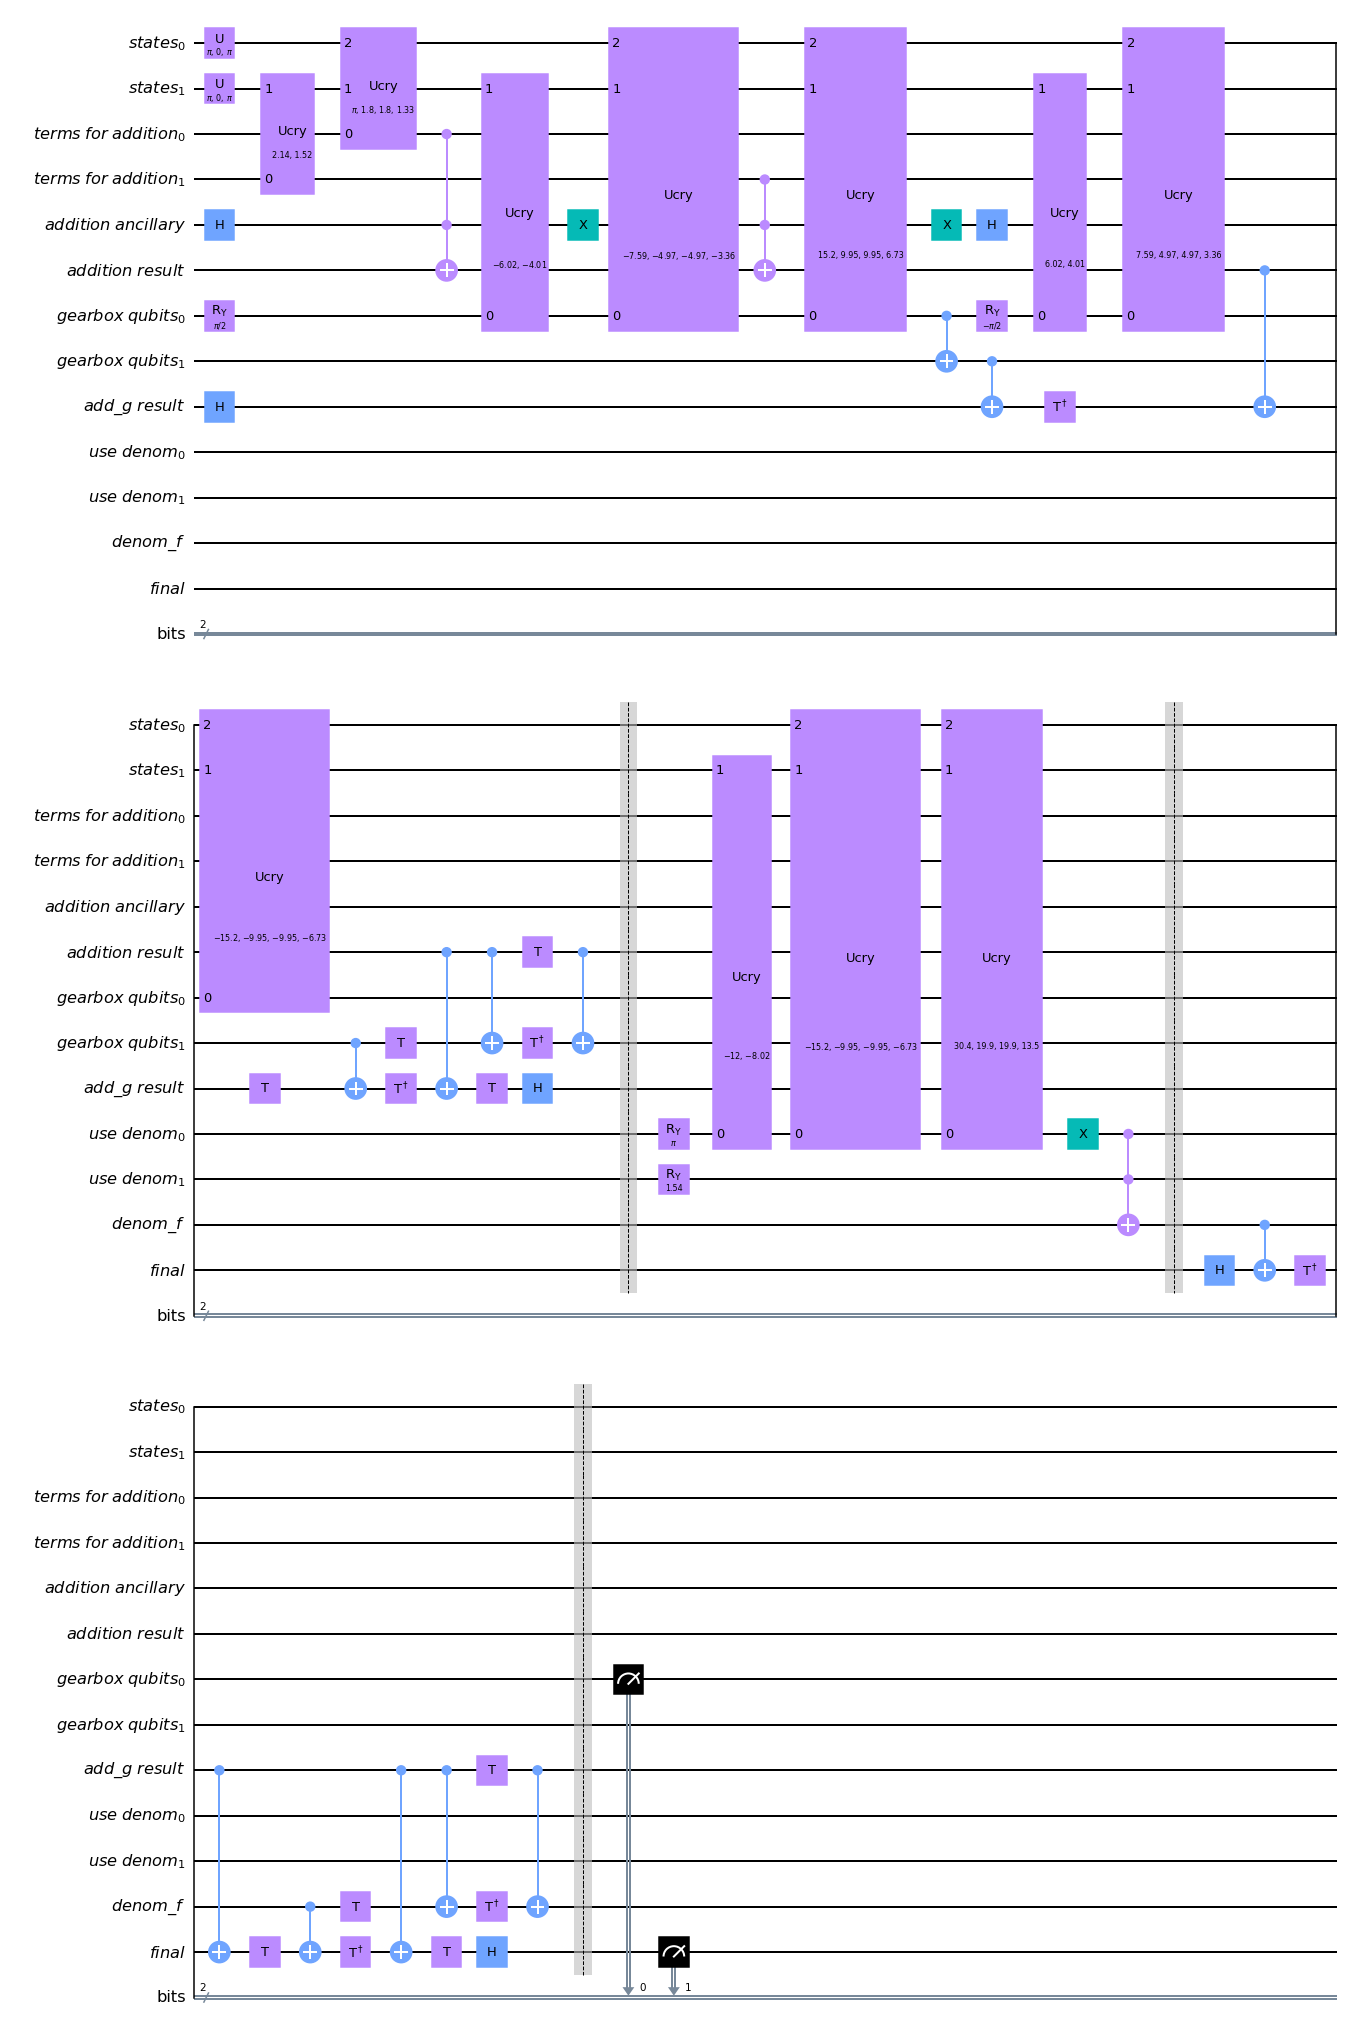

In [64]:
qc2.decompose().decompose().draw(output='mpl')

In [65]:
import datetime
date = datetime.datetime.now().strftime("%Hh%Mm%Ss_%d%m%Y")
file = 'asian_option_singleGB_individual_results_'+str(steps)+'steps_'+str(shots)+'shots_'+str(date)+'.json'
with open(file, 'w', encoding='utf-8') as f: json.dump(data_list, f, ensure_ascii=False, indent=4)